In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph,START,END
from dotenv import load_dotenv
from typing import TypedDict,Annotated
from pydantic import BaseModel,Field
import operator

In [2]:
load_dotenv()

True

In [3]:
model = ChatGoogleGenerativeAI(model ="gemini-2.5-flash")

In [4]:
class  Evaluation_Schema(BaseModel):

    feedback : str = Field(description=" Provide the description of the essay")
    score :float = Field(description="Provide score out of 10",ge=0,le=10)

In [5]:
structure_model = model.with_structured_output(Evaluation_Schema)

In [6]:
essay =  """India in the Age of AI
As the world enters a transformative era defined by artificial intelligence (AI), India stands at a critical juncture — one where it can either emerge as a global leader in AI innovation or risk falling behind in the technology race. The age of AI brings with it immense promise as well as unprecedented challenges, and how India navigates this landscape will shape its socio-economic and geopolitical future.

India's strengths in the AI domain are rooted in its vast pool of skilled engineers, a thriving IT industry, and a growing startup ecosystem. With over 5 million STEM graduates annually and a burgeoning base of AI researchers, India possesses the intellectual capital required to build cutting-edge AI systems. Institutions like IITs, IIITs, and IISc have begun fostering AI research, while private players such as TCS, Infosys, and Wipro are integrating AI into their global services. In 2020, the government launched the National AI Strategy (AI for All) with a focus on inclusive growth, aiming to leverage AI in healthcare, agriculture, education, and smart mobility.

One of the most promising applications of AI in India lies in agriculture, where predictive analytics can guide farmers on optimal sowing times, weather forecasts, and pest control. In healthcare, AI-powered diagnostics can help address India’s doctor-patient ratio crisis, particularly in rural areas. Educational platforms are increasingly using AI to personalize learning paths, while smart governance tools are helping improve public service delivery and fraud detection.

However, the path to AI-led growth is riddled with challenges. Chief among them is the digital divide. While metropolitan cities may embrace AI-driven solutions, rural India continues to struggle with basic internet access and digital literacy. The risk of job displacement due to automation also looms large, especially for low-skilled workers. Without effective skilling and re-skilling programs, AI could exacerbate existing socio-economic inequalities.

Another pressing concern is data privacy and ethics. As AI systems rely heavily on vast datasets, ensuring that personal data is used transparently and responsibly becomes vital. India is still shaping its data protection laws, and in the absence of a strong regulatory framework, AI systems may risk misuse or bias.

To harness AI responsibly, India must adopt a multi-stakeholder approach involving the government, academia, industry, and civil society. Policies should promote open datasets, encourage responsible innovation, and ensure ethical AI practices. There is also a need for international collaboration, particularly with countries leading in AI research, to gain strategic advantage and ensure interoperability in global systems.

India’s demographic dividend, when paired with responsible AI adoption, can unlock massive economic growth, improve governance, and uplift marginalized communities. But this vision will only materialize if AI is seen not merely as a tool for automation, but as an enabler of human-centered development.

In conclusion, India in the age of AI is a story in the making — one of opportunity, responsibility, and transformation. The decisions we make today will not just determine India’s AI trajectory, but also its future as an inclusive, equitable, and innovation-driven society."""

In [7]:
prompt = f"Evaluate the language quality of the following essay and provide feedback and assign score out of 10 \n {essay} "

In [8]:
structure_model.invoke(prompt).feedback

"The essay provides a comprehensive and well-structured analysis of India's position in the age of AI, effectively discussing both its immense potential and significant challenges. The language quality is excellent, characterized by clear, concise prose, a strong vocabulary, and varied sentence structures. The arguments are logically presented, moving from India's strengths and promising applications to the critical hurdles like the digital divide, job displacement, and data privacy. The essay maintains a coherent flow, making it easy to follow the author's line of reasoning. The conclusion effectively summarizes the key points and reinforces the importance of responsible AI adoption for India's future. Overall, it's a very strong and insightful piece."

In [9]:
structure_model.invoke(prompt).score

9.0

In [236]:
class UPSCstate(TypedDict):
    essay :str
    language_feedback : str
    analysis_feedback :str
    clarity_feedback :str
    overall_feedback: str
    individual_scores: Annotated[list[int],operator.add]
    avg_score :float


In [237]:
def  evaluate_langauge(state : UPSCstate):

    prompt =f"Evaluate the quality of the langauges and provide feedback and score out of 10  \n {state['essay']} "

    output =  structure_model.invoke(prompt)

    return {"language_feedback": output.feedback,'individual_scores':[output.score]}

In [238]:
def  evaluate_analysis(state : UPSCstate):
    
    prompt =f"Evaluate the quality of the analysis and provide feedback and score out of 10  \n {state['essay']} "

    output = structure_model.invoke(prompt)

    return {"analysis_feedback": output.feedback,'individual_scores':[output.score]}

In [239]:
def  evaluate_thoughts(state : UPSCstate):

    prompt =f"Evaluate the quality of the thoughts and provide feedback and score out of 10  \n {state['essay']} "

    output = structure_model.invoke(prompt)

    return {"clarity_feedback": output.feedback,'individual_scores':[output.score]}

In [247]:
def final_evaluation(state: UPSCstate):

    prompt = f" Based on the following feedback generate summarize feedback \n language_feedback - {state['language_feedback']} \n depth of analysis feedback - {state['analysis_feedback']} \n clarity_thoughts -{state['clarity_feedback']}]"

    overall_feedback = model.invoke(prompt).content

    avg_score = sum(state['individual_scores'])/len(state['individual_scores'])

    return {"overall_feedback":overall_feedback,'avg_score': avg_score}

In [248]:
graph  = StateGraph(UPSCstate)

In [249]:
graph.add_node('evaluate_langauge',evaluate_langauge)
graph.add_node('evaluate_analysis',evaluate_analysis)
graph.add_node('evaluate_thoughts', evaluate_thoughts) 
graph.add_node('final_evaluation',final_evaluation)

graph.add_edge(START,'evaluate_langauge')
graph.add_edge(START,'evaluate_analysis')
graph.add_edge(START,'evaluate_thoughts')

graph.add_edge('evaluate_langauge','final_evaluation')
graph.add_edge('evaluate_analysis','final_evaluation')
graph.add_edge('evaluate_thoughts','final_evaluation')

graph.add_edge('final_evaluation',END)


In [250]:
workflow = graph.compile()

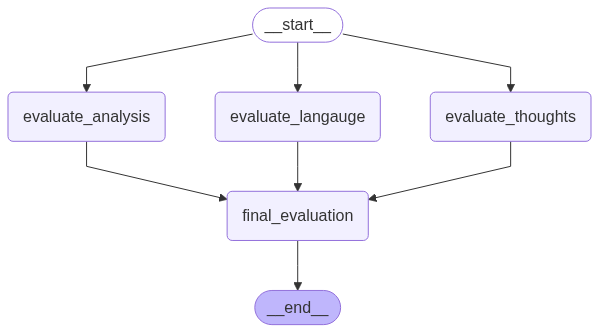

In [251]:
workflow

In [252]:
intial_state = {
    'essay' : essay
}

In [256]:
final_state = workflow.invoke(intial_state)
print(final_state)

{'essay': "India in the Age of AI\nAs the world enters a transformative era defined by artificial intelligence (AI), India stands at a critical juncture — one where it can either emerge as a global leader in AI innovation or risk falling behind in the technology race. The age of AI brings with it immense promise as well as unprecedented challenges, and how India navigates this landscape will shape its socio-economic and geopolitical future.\n\nIndia's strengths in the AI domain are rooted in its vast pool of skilled engineers, a thriving IT industry, and a growing startup ecosystem. With over 5 million STEM graduates annually and a burgeoning base of AI researchers, India possesses the intellectual capital required to build cutting-edge AI systems. Institutions like IITs, IIITs, and IISc have begun fostering AI research, while private players such as TCS, Infosys, and Wipro are integrating AI into their global services. In 2020, the government launched the National AI Strategy (AI for 

In [257]:
final_state['language_feedback']


'The essay demonstrates excellent language quality, characterized by clear and coherent argumentation, a sophisticated vocabulary, and a well-structured narrative. The content is comprehensive, addressing both the opportunities and challenges of AI in India with a balanced perspective. There are no noticeable grammatical errors or typos, and the flow of ideas is smooth and logical.'